In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_excel('Impact Data 1.xlsx')
df2 = pd.read_excel('Impact Data 2.xlsx')


In [3]:
df

,Angle,Velocity (s),Time (S),Force (kN)
0,15Â°,40.000000,0.000008,292.245763
1,15Â°,40.357143,0.000012,262.245763
2,15Â°,40.714286,0.000016,264.254237
3,15Â°,41.071429,0.000020,274.618644
4,15Â°,41.428571,0.000024,283.618644
...,...,...,...,...
192,15Â°,108.571429,0.000776,393.516949
193,15Â°,108.928571,0.000780,384.516949
194,15Â°,109.285714,0.000784,387.516949
195,15Â°,109.642857,0.000788,411.516949


In [4]:
# Scale the 'Maximum Principal Elastic Strain' column by 10^10
df['Time (S)'] = df['Time (S)'] * 1000000

# Optionally, check the updated values
print(df.head())

  Angle  Velocity (s)  Time (S)  Force (kN)
0  15Â°     40.000000       8.0  292.245763
1  15Â°     40.357143      12.0  262.245763
2  15Â°     40.714286      16.0  264.254237
3  15Â°     41.071429      20.0  274.618644
4  15Â°     41.428571      24.0  283.618644


In [5]:
df2

,Angle,Velocity (s),Time (S),Force (kN)
0,15Â°,40.000000,0.000008,254.245763
1,15Â°,40.357143,0.000012,247.245763
2,15Â°,40.714286,0.000016,240.254237
3,15Â°,41.071429,0.000020,239.618644
4,15Â°,41.428571,0.000024,239.618644
...,...,...,...,...
192,15Â°,108.571429,0.000776,368.516949
193,15Â°,108.928571,0.000780,368.516949
194,15Â°,109.285714,0.000784,368.516949
195,15Â°,109.642857,0.000788,368.516949


In [6]:
# Scale the 'Maximum Principal Elastic Strain' column by 10^10
df2['Time (S)'] = df2['Time (S)'] * 1000000

# Optionally, check the updated values
print(df.head())

  Angle  Velocity (s)  Time (S)  Force (kN)
0  15Â°     40.000000       8.0  292.245763
1  15Â°     40.357143      12.0  262.245763
2  15Â°     40.714286      16.0  264.254237
3  15Â°     41.071429      20.0  274.618644
4  15Â°     41.428571      24.0  283.618644


In [7]:
# Pearson Correlation
def calculate_pearson_correlation(data1, data2):
    corr, _ = pearsonr(data1['Force (kN)'], data2['Force (kN)'])
    return corr

# Root Mean Squared Error (RMSE)
def calculate_rmse(data1, data2):
    rmse = np.sqrt(mean_squared_error(data1['Force (kN)'], data2['Force (kN)']))
    return rmse

# Run calculations
pearson_correlation = calculate_pearson_correlation(df, df2)
rmse_values = calculate_rmse(df, df2)

# Output results
print("Pearson Correlation:", pearson_correlation)
print("RMSE Values:", rmse_values)

Pearson Correlation: 0.9880651728765102
RMSE Values: 34.177277457636144


In [8]:
from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [9]:
# Define the hyperparameter space
hyp_space  = [
    Integer(3, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std

In [10]:
# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    num_layers = params['num_layers']
    num_units = params['num_units']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = NN_model(num_layers, num_units, learning_rate, dropout_rate)

    # Define K-fold cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []

    # Perform cross-validation
    for train_idx, val_idx in kfold.split(df2[['Velocity (s)','Time (S)']]):
        X_train, X_val = df2[['Velocity (s)','Time (S)']].iloc[train_idx], df2[['Velocity (s)','Time (S)']].iloc[val_idx]
        y_train, y_val = df2[['Force (kN)']].iloc[train_idx], df2[['Force (kN)']].iloc[val_idx]

        # Standardize the features
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = scaler_x.transform(X_train)
        X_val_scaled = scaler_x.transform(X_val)

        # Train the model
        # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

        # Evaluate the model
        score = model.evaluate(X_val_scaled, y_val, verbose=0)
        scores.append(score)
    
    return np.mean(scores)

# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=30, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters
best_model = NN_model(
    num_layers=result.x[0],
    num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3],
)

Best hyperparameters:
num_layers: 10
num_units: 176
learning_rate: 0.0012111388858579383
dropout_rate: 0.0
batch_size: 20
epochs: 200


In [11]:
from sklearn.model_selection import train_test_split

train_X = df2[['Velocity (s)','Time (S)']].to_numpy()
train_y = df2['Force (kN)'].to_numpy()

# Standardize the initial dataset
scaler_x = StandardScaler().fit(train_X)
X_scaled = scaler_x.transform(train_X)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 82750.2969
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50329.0664 
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22588.3281 
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13465.7373 
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9120.8535  
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6424.3486 
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4708.5459 
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3513.8428 
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2518.3433 
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1386.3204 
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1213.7922 
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1113.6364
Epoch 13/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1101.7405 
Epoch 14/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1089.9498
Epoch 15/200


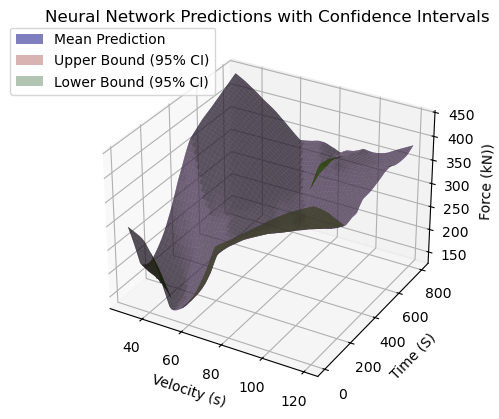

In [12]:
# Train the best model on training set
best_model.fit(X_scaled, train_y, epochs=result.x[5], batch_size=result.x[4], verbose=1)

# Produce Meshgrid of input space
x1_range = np.linspace(30, 120, 100)
x2_range  = np.linspace(5, 800, 100)

x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

x_grid = scaler_x.transform(x_grid)

# Perform MC Dropout predictions for entire meshgrid
pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

# Define range for inputs
bounds = np.array([[30, 120], [5, 800]])

# Identify top 10 points with highest uncertainty
num_new_points = 10

sampler = qmc.LatinHypercube(d=2)  # LHS in a 1D space
lhs_sample = sampler.random(n=1000)
lhs_points = qmc.scale(lhs_sample, bounds[:, 0], bounds[:, 1])

lhs_points_scaled = scaler_x.transform(lhs_points)

lhs_mean, lhs_std = mc_dropout_predictions(best_model, lhs_points_scaled)
percentile_threshold = 10 
threshold_value = np.percentile(lhs_mean, percentile_threshold)

# Filter points above the threshold
points_above_threshold = lhs_points[lhs_mean <= threshold_value]

num_new_points = 10
if len(points_above_threshold) > num_new_points:
    selected_indices = np.random.choice(len(points_above_threshold), num_new_points, replace=False)
    selected_points = points_above_threshold[selected_indices]
else:
    selected_points = points_above_threshold

new_points_df = pd.DataFrame(selected_points, columns=['x','y'])

# Ploting mean predictions and confidence intervals
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Reshaping predictions back to grid shape
pred_mean_grid = pred_mean.reshape(x1_grid.shape)
pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

# Getting mean of new points for visualization
new_x = new_points_df[['x', 'y']].to_numpy()
new_x = scaler_x.transform(new_x)
new_mean, new_std = mc_dropout_predictions(best_model, new_x)

# Plot Labels
ax.set_title('Neural Network Predictions with Confidence Intervals')
ax.set_xlabel('Velocity (s)')
ax.set_ylabel('Time (S)')
ax.set_zlabel('Force (kN))')

# Legend
legend_elements = [mean_surface, upper_surface, lower_surface]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()